**1. Thư viện**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from classification_models.tfkeras import Classifiers

from pathlib import Path

import pandas as pd
import numpy as np
import random

import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from classification_models.tfkeras import Classifiers

from tensorflow.keras import layers, models, optimizers

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Thiết lập random seed để tái lập kết quả
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Đã import thư viện và thiết lập seed thành công.')
# Khởi tạo ResNet và hàm tiền xử lý đặc thù của nó
ResNet50, preprocess_input = Classifiers.get('resnet50')
print("Đã import ResNet50 thành công")

Đã import thư viện và thiết lập seed thành công.
Đã import ResNet50 thành công


**2. Đường dẫn và cấu hình**

In [55]:
#Đường dẫn thư mục gốc và thư mục đầu ra
BASE_DIR = Path(r'D:\Khai_phá_dữ_liệu\BTN\Dataset.v2')
OUTPUT_DIR = Path(r'D:\Khai_phá_dữ_liệu\BTN\output_resnet')
#Đường dẫn tới các tệp CSV
HS_CSV = BASE_DIR / 'HS.csv'
LS_CSV = BASE_DIR / 'LS.csv'
#Đường dẫn tới các thư mục chứa tệp WAV
HS_WAV_DIR = BASE_DIR / 'HS' / 'HS'
LS_WAV_DIR = BASE_DIR / 'LS' / 'LS'
#Đường dẫn tới các thư mục đầu ra cho các tệp đã xử lý
MEL_IMAGES_DIR = OUTPUT_DIR / 'mel_images'
TRAIN_DIR = OUTPUT_DIR / 'train'
VAL_DIR = OUTPUT_DIR / 'val'
MODELS_DIR = OUTPUT_DIR / 'models'
#Tạo các thư mục đầu ra nếu chúng chưa tồn tại
for p in [MEL_IMAGES_DIR, TRAIN_DIR, VAL_DIR, MODELS_DIR]:
    p.mkdir(parents=True, exist_ok=True)
#Cấu hình xử lý âm thanh và hình ảnh
SAMPLE_RATE = 4000        # Hz
DURATION = 5              # giây
N_MELS = 128
IMAGE_SIZE = (128, 128)
#Cấu hình huấn luyện mô hình
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4

print("Cấu hình ResNet50 hoàn tất")
print(f"Dataset: {BASE_DIR}")
print(f"Output: {OUTPUT_DIR}")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Duration: {DURATION}s | Mel bands: {N_MELS}")
print(f"Image size: {IMAGE_SIZE}")


Cấu hình ResNet50 hoàn tất
Dataset: D:\Khai_phá_dữ_liệu\BTN\Dataset.v2
Output: D:\Khai_phá_dữ_liệu\BTN\output_resnet
Sample rate: 4000 Hz
Duration: 5s | Mel bands: 128
Image size: (128, 128)


**3. Đọc CSV và kiểm tra EDA**

In [4]:
# Đọc HS.csv và LS.csv
du_lieu_hs = pd.read_csv(HS_CSV)
du_lieu_ls = pd.read_csv(LS_CSV)

print('HS.csv - 5 dòng đầu:')
display(du_lieu_hs.head())
print('\nThông tin tổng quan HS.csv:')
du_lieu_hs.info()

print('\nLS.csv - 5 dòng đầu:')
display(du_lieu_ls.head())
print('\nThông tin tổng quan LS.csv:')
du_lieu_ls.info()


HS.csv - 5 dòng đầu:


,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB



Thông tin tổng quan HS.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gender            50 non-null     object
 1   Heart Sound Type  50 non-null     object
 2   Location          50 non-null     object
 3   Heart Sound ID    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB

LS.csv - 5 dòng đầu:


,Gender,Lung Sound Type,Location,Lung Sound ID
0,M,Normal,RUA,M_N_RUA
1,F,Normal,LUA,F_N_LUA
2,F,Normal,RMA,F_N_RMA
3,F,Normal,LMA,F_N_LMA
4,M,Normal,RLA,M_N_RLA



Thông tin tổng quan LS.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           50 non-null     object
 1   Lung Sound Type  50 non-null     object
 2   Location         50 non-null     object
 3   Lung Sound ID    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [5]:
# Kiểm tra số lượng file WAV trong thư mục HS và LS
so_wav_hs = len(list(HS_WAV_DIR.glob('*.wav'))) if HS_WAV_DIR.exists() else 0
so_wav_ls = len(list(LS_WAV_DIR.glob('*.wav'))) if LS_WAV_DIR.exists() else 0

print('Số file WAV HS:', so_wav_hs)
print('Số file WAV LS:', so_wav_ls)

Số file WAV HS: 50
Số file WAV LS: 50


In [6]:
# Thống kê bệnh & vị trí
print('Bảng chéo HS (bệnh - vị trí):')
bang_cheo_hs = pd.crosstab(du_lieu_hs['Heart Sound Type'], du_lieu_hs['Location'])
display(bang_cheo_hs)

print('\nBảng chéo LS (bệnh - vị trí):')
bang_cheo_ls = pd.crosstab(du_lieu_ls['Lung Sound Type'], du_lieu_ls['Location'])
display(bang_cheo_ls)


Bảng chéo HS (bệnh - vị trí):


Location,Apex,LC,LLSB,LUSB,RC,RUSB
Heart Sound Type,,,,,,
AV Block,1,0,1,0,1,0
Atrial Fibrillation,1,1,0,1,0,1
Early Systolic Murmur,1,0,1,2,0,2
Late Diastolic Murmur,1,1,2,2,0,0
Late Systolic Murmur,1,0,1,2,0,1
Mid Systolic Murmur,2,0,1,2,1,1
Normal,1,2,2,1,1,2
S3,1,1,2,1,0,0
S4,0,0,0,1,1,0



Bảng chéo LS (bệnh - vị trí):


Location,LLA,LMA,LUA,RLA,RMA,RUA
Lung Sound Type,,,,,,
Coarse Crackles,2,2,2,2,1,0
Fine Crackles,0,0,2,2,0,1
Normal,2,2,2,2,2,2
Pleural Rub,2,2,2,1,1,1
Rhonchi,1,2,2,2,0,1
Wheezing,1,1,1,1,1,2


In [7]:
# Thống kê giới tính
print('Giới tính HS:')
display(du_lieu_hs['Gender'].value_counts())
print('Giới tính LS:')
display(du_lieu_ls['Gender'].value_counts())

Giới tính HS:


Gender
F    26
M    24
Name: count, dtype: int64

Giới tính LS:


Gender
M    30
F    20
Name: count, dtype: int64

**4. Trực quan hoá dữ liệu âm thanh**

In [8]:
# Chọn 1 file mẫu mỗi loại để trực quan
ds_hs = sorted(list(HS_WAV_DIR.glob('*.wav')))
ds_ls = sorted(list(LS_WAV_DIR.glob('*.wav')))

if len(ds_hs) == 0 or len(ds_ls) == 0:
    raise FileNotFoundError('Không tìm thấy file wav trong HS hoặc LS. Hãy kiểm tra lại đường dẫn dữ liệu.')

wav_mau_hs = ds_hs[0]
wav_mau_ls = ds_ls[0]

print('File mẫu HS:', wav_mau_hs.name)
print('File mẫu LS:', wav_mau_ls.name)


File mẫu HS: F_AF_A.wav
File mẫu LS: F_CC_LLA.wav


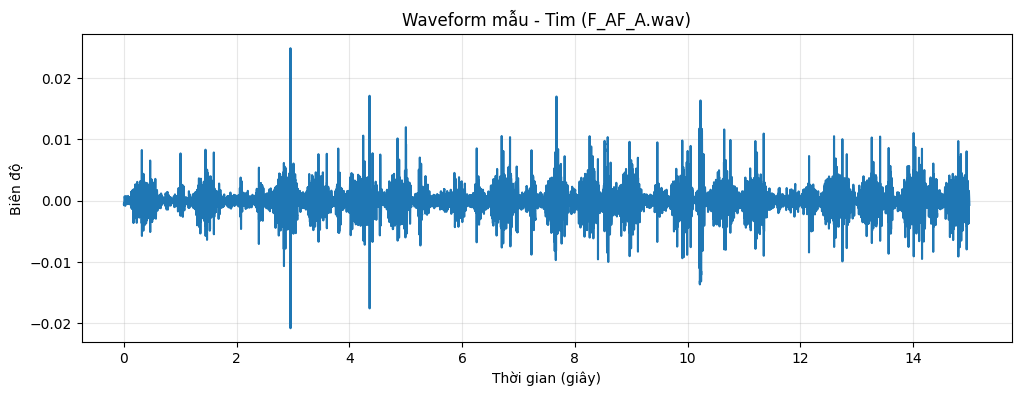

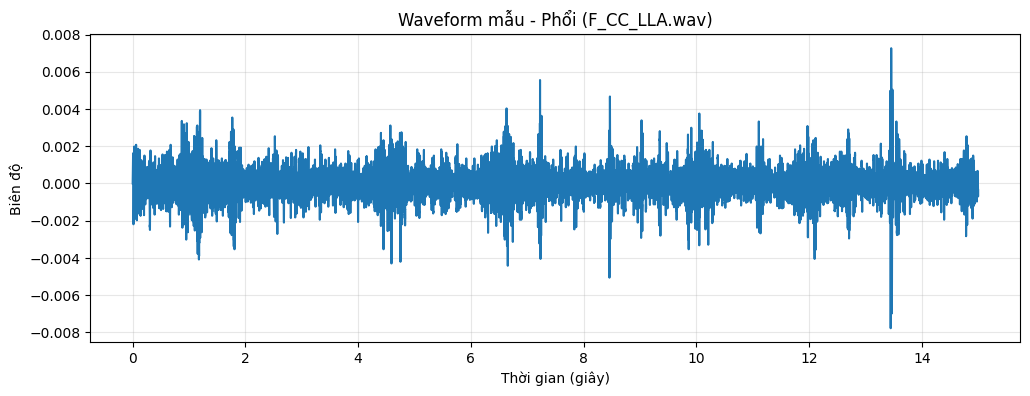

In [9]:
# Vẽ waveform mẫu
def ve_waveform(path_wav: Path, tieu_de: str):
  
    y, sr = librosa.load(path_wav, sr=None)

    # Vẽ dạng sóng
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(y)) / sr, y)
    plt.title(tieu_de)
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Biên độ')
    plt.grid(alpha=0.3)
    plt.show()

ve_waveform(wav_mau_hs, f'Waveform mẫu - Tim ({wav_mau_hs.name})')
ve_waveform(wav_mau_ls, f'Waveform mẫu - Phổi ({wav_mau_ls.name})')

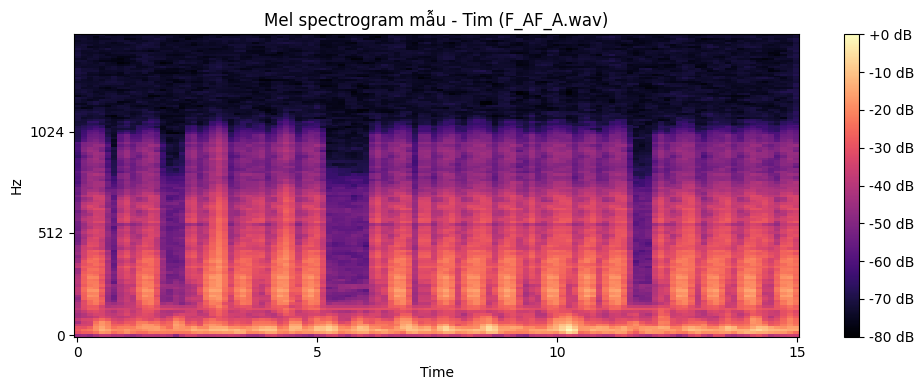

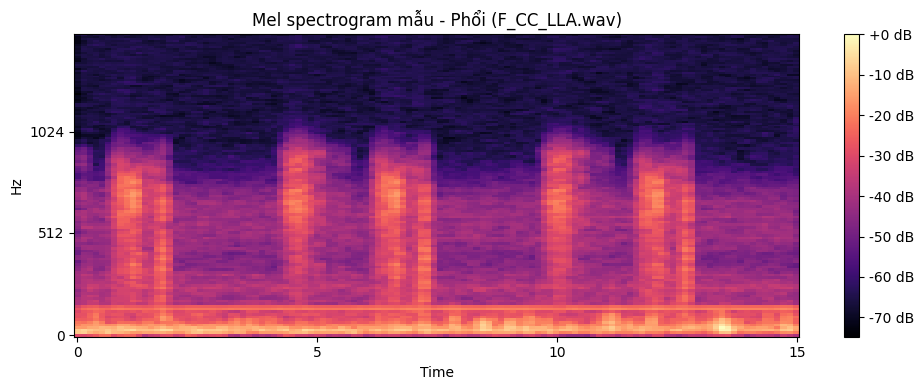

In [10]:
# Vẽ Mel spectrogram mẫu
def ve_mel_spectrogram(path_wav: Path, tieu_de: str, so_mel: int = 128):
    y, sr = librosa.load(path_wav, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=so_mel)
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(tieu_de)
    plt.tight_layout()
    plt.show()

ve_mel_spectrogram(wav_mau_hs, f'Mel spectrogram mẫu - Tim ({wav_mau_hs.name})')
ve_mel_spectrogram(wav_mau_ls, f'Mel spectrogram mẫu - Phổi ({wav_mau_ls.name})')

**5. Tiền xử lý**

In [11]:
# Thiết lập tham số chuẩn
tan_so_mau = 4000
do_dai_giay = 5
so_mel = 128

print('Tham số tiền xử lý:')
print('- Tần số mẫu:', tan_so_mau)
print('- Độ dài chuẩn (giây):', do_dai_giay)
print('- Số Mel bands:', so_mel)


Tham số tiền xử lý:
- Tần số mẫu: 4000
- Độ dài chuẩn (giây): 5
- Số Mel bands: 128


In [39]:
def tien_xu_ly(path_wav, tan_so_mau, do_dai_giay, so_mel):
    try:
        y, sr = librosa.load(path_wav, sr=tan_so_mau)
        do_dai_mau = tan_so_mau * do_dai_giay
        if len(y) > do_dai_mau:
            y = y[:do_dai_mau]
        else:
            y = np.pad(y, (0, max(0, do_dai_mau - len(y))))
            
        # Tạo Mel-spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=so_mel)
        S_dB = librosa.power_to_db(S, ref=np.max)
        S_norm = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min()) * 255
        S_norm = S_norm.astype(np.uint8)
        
        # Chuyển thành 3 kênh (RGB) để ResNet50 hiểu được
        img_3ch = np.stack([S_norm] * 3, axis=-1)
        
        return img_3ch
    except Exception as e:
        print(f"Lỗi xử lý file {path_wav}: {e}")
        return None
    # Test hàm
mel_test = tien_xu_ly(wav_mau_hs, tan_so_mau, do_dai_giay, so_mel)
print(f'Kích thước mel spectrogram: {mel_test.shape}')
print(f'Khoảng giá trị: [{mel_test.min():.2f}, {mel_test.max():.2f}] dB')

Kích thước mel spectrogram: (128, 40, 3)
Khoảng giá trị: [0.00, 255.00] dB


In [13]:
def tien_xu_ly_thu_muc(ds_wav, tan_so_mau, do_dai_giay, so_mel, nhan):
    X = []
    y = []

    for p in ds_wav:
        try:
            mel = tien_xu_ly(p, tan_so_mau, do_dai_giay, so_mel)
            if mel is not None: 
                X.append(mel)
                y.append(nhan)
        except Exception as e:
            print(f'Lỗi khi xử lý {p.name}: {e}')

    return np.array(X), np.array(y)

X_hs, y_hs = tien_xu_ly_thu_muc(ds_hs, tan_so_mau, do_dai_giay, so_mel, nhan=0)
X_ls, y_ls = tien_xu_ly_thu_muc(ds_ls, tan_so_mau, do_dai_giay, so_mel, nhan=1)

print('HS:', X_hs.shape, y_hs.shape)
print('LS:', X_ls.shape, y_ls.shape)

HS: (50, 128, 40, 3) (50,)
LS: (50, 128, 40, 3) (50,)


**6. Lưu Mel images**

In [14]:
# Tạo thư mục lưu ảnh
thu_muc_du_lieu = Path(r'D:\Khai_phá_dữ_liệu\BTN\Dataset.v2')
thu_muc_anh_mel = thu_muc_du_lieu / 'mel_images'
(thu_muc_anh_mel / 'HS').mkdir(parents=True, exist_ok=True)
(thu_muc_anh_mel / 'LS').mkdir(parents=True, exist_ok=True)

print('Thư mục lưu ảnh Mel:', thu_muc_anh_mel)

Thư mục lưu ảnh Mel: D:\Khai_phá_dữ_liệu\BTN\Dataset.v2\mel_images


In [40]:
# Hàm lưu 1 Mel spectrogram thành PNG
def luu_mel_anh(mel_db: np.ndarray, path_png: Path):
    """
    Lưu Mel Spectrogram thành ảnh PNG
    """
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(mel_db, aspect='auto', origin='lower', cmap='magma')
    plt.savefig(path_png, bbox_inches='tight', pad_inches=0)
    plt.close()
    # Test hàm
dau_ra_test = OUTPUT_DIR / 'test_mel.png'
luu_mel_anh(mel_test, dau_ra_test)
print(f'Đã lưu ảnh test: {dau_ra_test}')


Đã lưu ảnh test: D:\Khai_phá_dữ_liệu\BTN\output_resnet\test_mel.png


In [19]:
def xu_ly_va_luu(ds_wav, label: str):
    loi = 0
    for p in ds_wav:
        try:
            mel = tien_xu_ly(p, tan_so_mau, do_dai_giay, so_mel)
            luu_mel_anh(mel, thu_muc_anh_mel / label / f'{p.stem}.png')
        except Exception as e:
            loi += 1
            print(f'Lỗi {label} - {p.name}: {e}')
    return loi


In [20]:
so_loi = 0

print('Đang xử lý Heart Sound...')
so_loi += xu_ly_va_luu(ds_hs, 'HS')

print('Đang xử lý Lung Sound...')
so_loi += xu_ly_va_luu(ds_ls, 'LS')

print('Hoàn tất. Tổng số lỗi:', so_loi)


Đang xử lý Heart Sound...
Đang xử lý Lung Sound...
Hoàn tất. Tổng số lỗi: 0


In [22]:
# Đếm số ảnh đã lưu
anh_hs = list((thu_muc_anh_mel / 'HS').glob('*.png'))
anh_ls = list((thu_muc_anh_mel / 'LS').glob('*.png'))

print(f'Số ảnh HS: {len(anh_hs)}')
print(f'Số ảnh LS: {len(anh_ls)}')
print(f'Tổng: {len(anh_hs) + len(anh_ls)} ảnh')


Số ảnh HS: 50
Số ảnh LS: 50
Tổng: 100 ảnh


**7. Chia train/val và tạo cấu trúc thư mục**

In [ ]:
#load ds  ảnh và nhãn
danh_sach_file = []
danh_sach_nhan = []

for duongdananh in anh_hs:
    danh_sach_file.append(str(duongdananh))
    danh_sach_nhan.append(0)

for duongdananh in anh_ls:
    danh_sach_file.append(str(duongdananh))
    danh_sach_nhan.append(1)

tat_ca_anh_path = np.array(danh_sach_file)
tat_ca_nhan_label = np.array(danh_sach_nhan)

print(f'--- THỐNG KÊ DỮ LIỆU ẢNH MEL ---')
print(f'Tổng số lượng ảnh thu được: {len(tat_ca_anh_path)}')
print(f'Số lượng mẫu HS: {np.sum(tat_ca_nhan_label == 0)}')
print(f'Số lượng mẫu LS: {np.sum(tat_ca_nhan_label == 1)}')

--- THỐNG KÊ DỮ LIỆU ẢNH MEL ---
Tổng số lượng ảnh thu được: 100
Số lượng mẫu HS: 50
Số lượng mẫu LS: 50


In [29]:
danh_sach_nhan = np.array(danh_sach_nhan).astype(int)
danh_sach_file = np.array(danh_sach_file)
# Chia train/validation với stratify
X_train, X_val, y_train, y_val = train_test_split(
    danh_sach_file, danh_sach_nhan, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=danh_sach_nhan
)

print(f'Tập train: {len(X_train)} ảnh')
print(f'  - HS: {np.sum(y_train==0)}, LS: {np.sum(y_train==1)}')
print(f'Tập validation: {len(X_val)} ảnh')
print(f'  - HS: {np.sum(y_val==0)}, LS: {np.sum(y_val==1)}')

Tập train: 80 ảnh
  - HS: 40, LS: 40
Tập validation: 20 ảnh
  - HS: 10, LS: 10


In [30]:
import shutil

def tao_cau_truc_train_val(train_dir: Path, val_dir: Path):
    for folder in [train_dir, val_dir]:
        for lop in ['HS', 'LS']:
            (folder / lop).mkdir(parents=True, exist_ok=True)
tao_cau_truc_train_val(TRAIN_DIR, VAL_DIR)
def copy_anh_theo_nhan(ds_anh, ds_nhan, thu_muc_dich: Path):
    for path_anh, nhan in zip(ds_anh, ds_nhan):
        lop = 'HS' if nhan == 0 else 'LS'
        dich = thu_muc_dich / lop / Path(path_anh).name
        shutil.copy(path_anh, dich)
copy_anh_theo_nhan(X_train, y_train, TRAIN_DIR)
copy_anh_theo_nhan(X_val, y_val, VAL_DIR)
def thong_ke(folder: Path):
    return {
        'HS': len(list((folder / 'HS').glob('*.png'))),
        'LS': len(list((folder / 'LS').glob('*.png')))
    }

print('Train:', thong_ke(TRAIN_DIR))
print('Val  :', thong_ke(VAL_DIR))


Train: {'HS': 40, 'LS': 40}
Val  : {'HS': 10, 'LS': 10}


**8. Data Augmentation và Data Generators**

In [31]:
img_size = (128, 128)
batch_size = 16
# Tạo ImageDataGenerator với tăng cường dữ liệu cho tập huấn luyện
bo_sinh_du_lieu_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)

bo_sinh_du_lieu_val = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
#Load dữ liệu
tap_train = bo_sinh_du_lieu_train.flow_from_directory(
    TRAIN_DIR, 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

tap_val = bo_sinh_du_lieu_val.flow_from_directory(
    VAL_DIR,                  
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
print("Class indices:", tap_train.class_indices)


Found 80 images belonging to 2 classes.


Found 20 images belonging to 2 classes.
Class indices: {'HS': 0, 'LS': 1}


**9. MÔ hình CNN baseline**

In [43]:
def mo_hinh_Cnn(
    kich_thuoc_dau_vao=(128, 128, 3),
    so_lop=2
):
    mo_hinh = models.Sequential([

        layers.Input(shape=kich_thuoc_dau_vao),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Classifier
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),

        # Output: 2 lớp
        layers.Dense(so_lop, activation='softmax')
    ])

    mo_hinh.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return mo_hinh
# Tạo model
mo_hinh_cnn = mo_hinh_Cnn(kich_thuoc_dau_vao=(img_size[0], img_size[1], 3))
mo_hinh_cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,439,106 (5.49 MB)

 Trainable params: 1,438,146 (5.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [56]:
mo_hinh_cnn.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

print('Đã biên dịch model thành công!')

Đã biên dịch model thành công!


In [57]:
# Callbacks cho CNN
cac_callback_cnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # Lưu model tốt nhất
    ModelCheckpoint(
        filepath='cnn_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]
SO_EPOCH = 50

print('Bắt đầu huấn luyện CNN Baseline...')

lich_su_cnn = mo_hinh_cnn.fit(
    tap_train,
    validation_data=tap_val,
    epochs=SO_EPOCH,
    callbacks=cac_callback_cnn,
    verbose=1
)

print('Hoàn tất huấn luyện CNN Baseline')


Bắt đầu huấn luyện CNN Baseline...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.6131 - loss: 0.7206
Epoch 1: val_accuracy improved from None to 0.50000, saving model to cnn_best.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 701ms/step - accuracy: 0.5500 - loss: 0.8791 - val_accuracy: 0.5000 - val_loss: 7.0478 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6071 - loss: 0.6621
Epoch 2: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - accuracy: 0.5875 - loss: 0.6407 - val_accuracy: 0.5000 - val_loss: 9.0543 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6610 - loss: 0.8398
Epoch 3: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - accuracy: 0.6750 - loss: 0.7821 - val_accuracy: 0.5000 - val_loss: 8.2403 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6560 - loss: 0.6388
Epoch 4: Reduc

**10. Model Resnet50 Transfer learning**

In [58]:
# Cấu hình các tham số
img_size = (128, 128)
batch_size = 16

# 1. Định nghĩa Augmentation
bo_sinh_du_lieu_train_res = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    validation_split=0.2,                    
    rotation_range=10,                       
    width_shift_range=0.1,                   
    height_shift_range=0.1,                  
    horizontal_flip=True,                    
    fill_mode='nearest'
)

bo_sinh_du_lieu_val_res = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

tap_train_res = bo_sinh_du_lieu_train_res.flow_from_directory(
    TRAIN_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=42
)

tap_val_res = bo_sinh_du_lieu_val_res.flow_from_directory(
    TRAIN_DIR, 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse', 
    subset='validation',
    shuffle=False
)

print("Class indices:", tap_train_res.class_indices)

Found 64 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Class indices: {'HS': 0, 'LS': 1}


In [59]:

def xay_dung_resnet50_transfer(input_shape=(128, 128, 3), so_lop=2):
    # Load mô hình ResNet50 gốc (CNN cơ bản) từ Keras Applications
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Đóng băng các lớp của base_model (Transfer Learning)
    base_model.trainable = False 
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(so_lop, activation='softmax') 
    ])
    
    # Compile mô hình
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy' if so_lop > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model
resnet50_model = xay_dung_resnet50_transfer(input_shape=(128, 128, 3), so_lop=2)
resnet50_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ (None, 4, 4, 2048)     │    23,546,057 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,071,115 (91.82 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,546,057 (89.82 MB)

In [62]:
resnet50_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print('Đã biên dịch model thành công')

Đã biên dịch model thành công


In [63]:
# Cấu hình tham số học tập
TY_LE_HOC_BAT_DAU = 1e-4 
SO_EPOCH = 50

# Tính toán lịch trình giảm tỷ lệ học 
tong_buoc = len(tap_train_res) * SO_EPOCH
lich_trinh_lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=TY_LE_HOC_BAT_DAU,
    decay_steps=tong_buoc,
    alpha=0.1
)

# 3. Compile mô hình ResNet50 (Sửa tên biến từ resnet18_model thành resnet50_model)
resnet50_model.compile(
    optimizer=Adam(learning_rate=lich_trinh_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] 
)

print(f"Mô hình ResNet50 đã compile với Cosine Decay LR!")

callbacks_resnet50 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        filepath='resnet50_best_model.keras', 
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]
print("Callbacks cho ResNet50 đã được cấu hình xong!")

Mô hình ResNet50 đã compile với Cosine Decay LR!
Callbacks cho ResNet50 đã được cấu hình xong!


In [64]:
print('--- BẮT ĐẦU HUẤN LUYỆN RESNET50 ---')
lich_su_resnet50 = resnet50_model.fit(
    tap_train_res,
    validation_data=tap_val_res,
    epochs=50,
    callbacks=callbacks_resnet50,
    verbose=1
)
print('--- HOÀN TẤT ---')

--- BẮT ĐẦU HUẤN LUYỆN RESNET50 ---
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.4518 - loss: 0.8068
Epoch 1: val_accuracy improved from None to 0.50000, saving model to resnet50_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4219 - loss: 0.8553 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5872 - loss: 0.6613
Epoch 2: val_accuracy improved from 0.50000 to 0.75000, saving model to resnet50_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6406 - loss: 0.5995 - val_accuracy: 0.7500 - val_loss: 0.5167
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9154 - loss: 0.3574
Epoch 3: val_accuracy improved from 0.75000 to 0.87500, saving model to resnet50_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8594 - loss: 0.3947 - val_accuracy: 0.8750 - val_loss: 0.3926
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9167 - loss: 0.3296


**11. So sánh và đánh giá mô hình** 

In [70]:
# Dự đoán với Cnn ban đầu
Y_pred_res = resnet50_model.predict(tap_val)
y_pred_res = np.argmax(Y_pred_res, axis=1)
y_true_res = tap_val.classes

# In báo cáo
from sklearn.metrics import classification_report, confusion_matrix
print("BÁO CÁO KẾT QUẢ Cnn ban đầu:")
print(classification_report(y_true_res, y_pred_res, target_names=list(tap_val.class_indices.keys())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
BÁO CÁO KẾT QUẢ Cnn ban đầu:
              precision    recall  f1-score   support

          HS       0.91      1.00      0.95        10
          LS       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [68]:
# Dự đoán với ResNet50
Y_pred_res = resnet50_model.predict(tap_val_res)
y_pred_res = np.argmax(Y_pred_res, axis=1)
y_true_res = tap_val_res.classes

# In báo cáo
from sklearn.metrics import classification_report, confusion_matrix
print("BÁO CÁO KẾT QUẢ RESNET50:")
print(classification_report(y_true_res, y_pred_res, target_names=list(tap_val_res.class_indices.keys())))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
BÁO CÁO KẾT QUẢ RESNET50:
              precision    recall  f1-score   support

          HS       0.89      1.00      0.94         8
          LS       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



11.1 Biểu đồ quá trình huấn luyện (Loss & Accuracy)

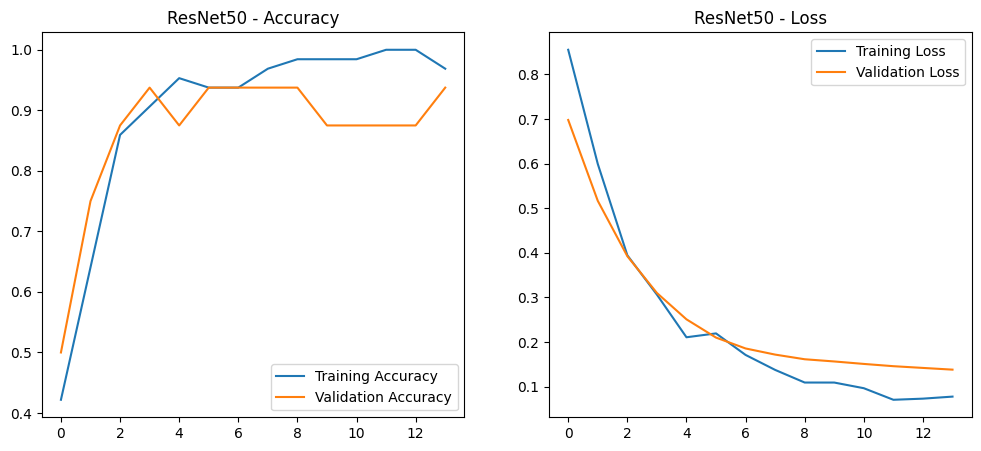

In [71]:
def ve_bieu_do_lich_su(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.show()

ve_bieu_do_lich_su(lich_su_resnet50, "ResNet50")

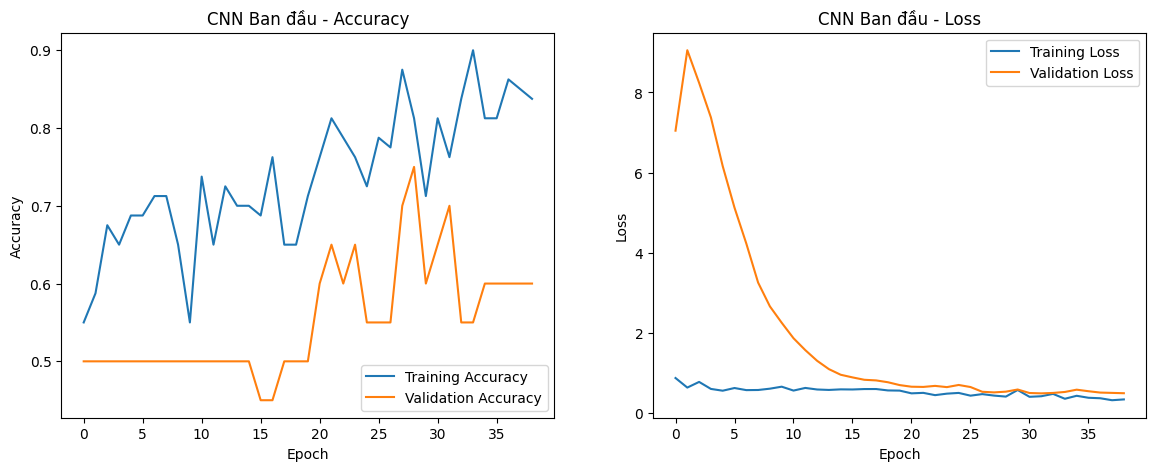

In [72]:
def ve_bieu_do_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('CNN Ban đầu - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('CNN Ban đầu - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()
ve_bieu_do_history(lich_su_cnn)

So sánh đặc điểm: 

Cnn ban đầu: 
- Tốc độ học: Chậm, mất nhiều thời gian để bắt đầu hiểu dữ liệu.
- Độ ổn định: Thấp, các chỉ số nhảy loạn xạ.
- Độ chính xác thực tế:	Khoảng 60% - 70% (kém ổn định).
Resnet50: 	 
- Tốc độ học: Cực nhanh, hiệu quả ngay từ những epoch đầu.
- Độ ổn định: Cao, đường cong mượt mà, đáng tin cậy.
Độ chính xác thực tế: ~94% (rất ổn định).

11.2. Ma trận nhầm lẫn (Confusion Matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


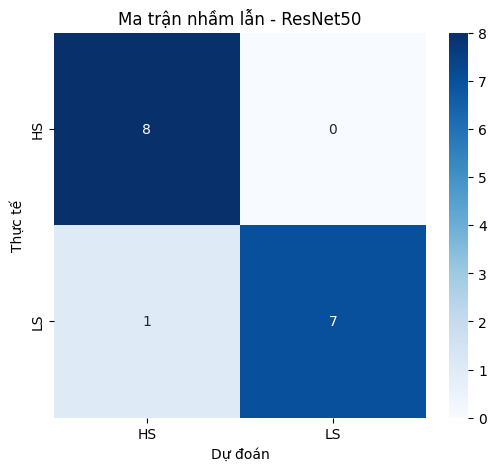

              precision    recall  f1-score   support

          HS       0.89      1.00      0.94         8
          LS       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



In [75]:
# Dự đoán trên tập Validation
Y_pred = resnet50_model.predict(tap_val_res)
y_pred = np.argmax(Y_pred, axis=1)

y_true = tap_val_res.classes

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=tap_val_res.class_indices.keys(),
            yticklabels=tap_val_res.class_indices.keys())
plt.title('Ma trận nhầm lẫn - ResNet50')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

print(classification_report(y_true, y_pred, target_names=list(tap_val_res.class_indices.keys())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 


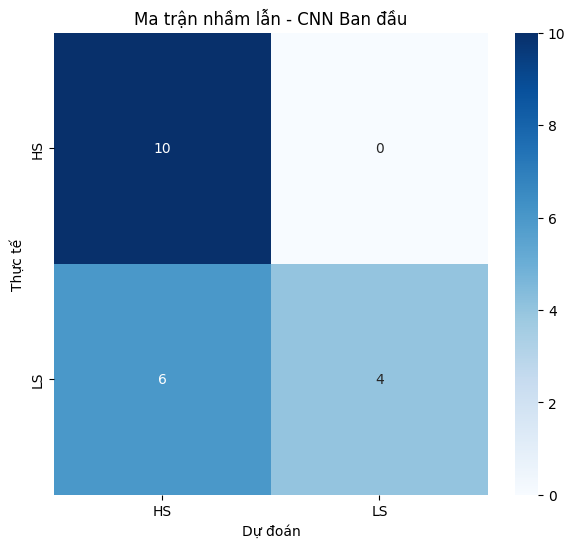


Báo cáo phân loại chi tiết:
              precision    recall  f1-score   support

          HS       0.62      1.00      0.77        10
          LS       1.00      0.40      0.57        10

    accuracy                           0.70        20
   macro avg       0.81      0.70      0.67        20
weighted avg       0.81      0.70      0.67        20



In [76]:
Y_pred = mo_hinh_cnn.predict(tap_val) 
y_pred = np.argmax(Y_pred, axis=1)
y_true = tap_val.classes
class_names = list(tap_val.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Ma trận nhầm lẫn - CNN Ban đầu')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

print("\nBáo cáo phân loại chi tiết:")
print(classification_report(y_true, y_pred, target_names=class_names))

1. So sánh hiệu suất tổng thể (Accuracy)

CNN Baseline: Đạt độ chính xác 70% trên tập Validation.

ResNet50: Đạt độ chính xác ấn tượng 94% trên tập Validation.

Nhận xét: Việc chuyển đổi sang ResNet50 đã giúp cải thiện hiệu suất thêm 24%, đưa mô hình từ mức trung bình lên mức tốt cho các ứng dụng thực tế.